In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
img_size = 32
transform = transforms.Compose(
    [transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_data = torchvision.datasets.GTSRB(root='./', split='train',  download=True, transform=transform)
test_data = torchvision.datasets.GTSRB(root='./', split='test', download=True, transform=transform)

train_data, val_data = torch.utils.data.random_split(train_data, [0.9, 0.1], torch.Generator().manual_seed(42))

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

from pandas.io.parsers import read_csv
classes = read_csv("signnames.csv").values[:, 1]
classes

array(['Speed limit (20km/h)', 'Speed limit (30km/h)',
       'Speed limit (50km/h)', 'Speed limit (60km/h)',
       'Speed limit (70km/h)', 'Speed limit (80km/h)',
       'End of speed limit (80km/h)', 'Speed limit (100km/h)',
       'Speed limit (120km/h)', 'No passing',
       'No passing for vehicles over 3.5 metric tons',
       'Right-of-way at the next intersection', 'Priority road', 'Yield',
       'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited',
       'No entry', 'General caution', 'Dangerous curve to the left',
       'Dangerous curve to the right', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End of all speed and passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep le

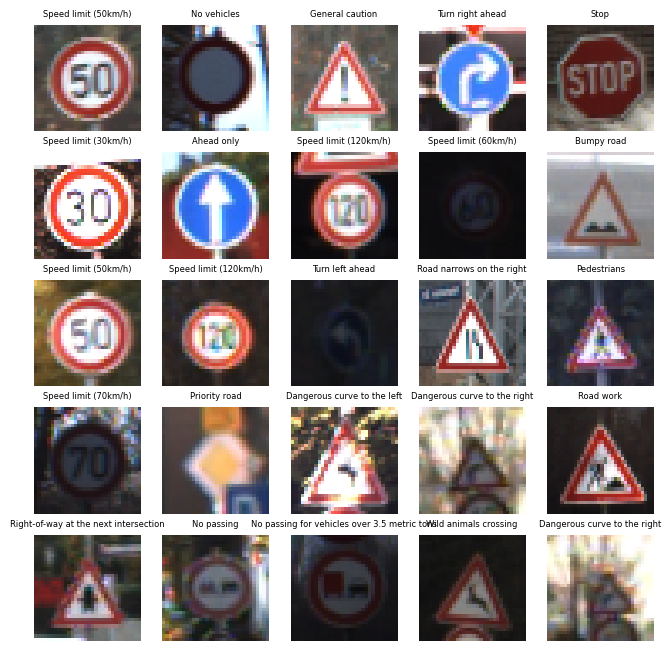

In [ ]:
# function to show images
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  # get some random training images
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]

  img = img + 0.5  # unnormalize

  figure.add_subplot(rows, cols, i)
  # print labels
  plt.title(classes[label], fontsize=6)
  plt.axis("off")
  # show images
  plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 4, 3)
        self.fc1 = nn.Linear(4 * 6 * 6, 120) # why 13*13???
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class BiggerNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.batchnorm1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 128, 3)
    self.batchnorm2 = nn.BatchNorm2d(128)

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 5 * 5, 512)
    # self.batchnorm3 = nn.BatchNorm2d(512)
    self.dropout = nn.Dropout()

    self.linear2 = nn.Linear(512, 43)
    self.softmax = nn.Softmax()

    self.maxpool = nn.MaxPool2d((2, 2))
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = self.batchnorm1(x)

    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x = self.maxpool(x)
    x = self.batchnorm2(x)

    x = self.flatten(x)
    x = self.relu(self.linear1(x))
    # x = self.batchnorm3(x)
    x = self.dropout(x)

    x = self.softmax(self.linear2(x))

    return x



net = BiggerNet()
net.to(device)

BiggerNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3200, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=43, bias=True)
  (softmax): Softmax(dim=None)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
plot_train_loss = []
plot_val_loss = []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    p_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            # plot_train_loss.append(running_loss / 2000)
            p_loss += running_loss
            running_loss = 0.0

    plot_train_loss.append(running_loss / i)

    runnung_val_loss = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            runnung_val_loss += loss.item()

    plot_val_loss.append(runnung_val_loss / i)
    print(f'epoch {epoch + 1}: train loss = {plot_train_loss[-1]}, validation loss = {plot_val_loss[-1]}')

    # print(f'epoch {epoch}: validation loss = {plot_val_loss}')


print('Finished Training')

epoch 1: train loss = 3.455861874989101, validation loss = 3.3078419587698327
epoch 2: train loss = 3.234735422045271, validation loss = 3.240745446768152
epoch 3: train loss = 3.118405471656606, validation loss = 3.0945801246597107
epoch 4: train loss = 3.032925064636964, validation loss = 3.055709330432386
epoch 5: train loss = 3.011175572633425, validation loss = 3.0539342495332282
epoch 6: train loss = 3.002372907541782, validation loss = 3.028452060308801
epoch 7: train loss = 2.9703774197556783, validation loss = 3.0050977281777254
epoch 8: train loss = 2.9583614738347217, validation loss = 2.99787313966866
epoch 9: train loss = 2.9440244759354637, validation loss = 2.9765078389501
epoch 10: train loss = 2.9310050274883315, validation loss = 2.9670923646674097
epoch 11: train loss = 2.8954134378955265, validation loss = 2.915806646806648
epoch 12: train loss = 2.87874508572516, validation loss = 2.9016077949340087
epoch 13: train loss = 2.857827867143781, validation loss = 2.8909

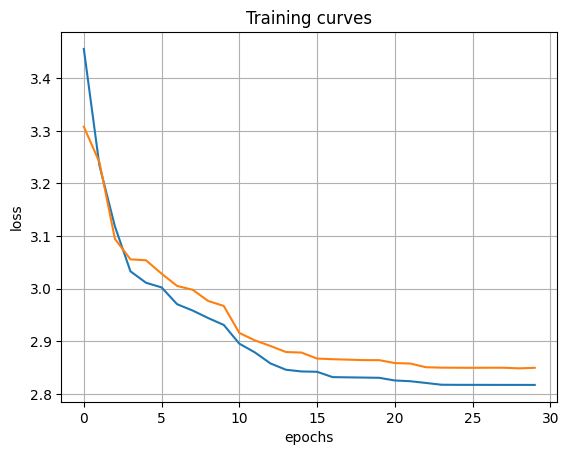

In [ ]:
fig, ax = plt.subplots()
ax.set(xlabel='epochs', ylabel='loss',
                  title='Training curves')
t = range(len(plot_train_loss))
t_val = range(len(plot_val_loss))

ax.plot(t, plot_train_loss)
ax.plot(t, plot_val_loss)

ax.grid()
plt.show()

In [ ]:
PATH = './gtsrb_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

GroundTruth:  Vehicles over 3.5 metric tons prohibited Speed limit (30km/h) Keep right Turn right ahead Right-of-way at the next intersection Keep right General caution Priority road Road work Ahead only Priority road Speed limit (100km/h) Slippery road Speed limit (100km/h) Speed limit (70km/h) No passing Double curve Dangerous curve to the right Pedestrians Keep right Speed limit (70km/h) Turn right ahead No passing Speed limit (60km/h) Speed limit (30km/h) Right-of-way at the next intersection Yield No passing for vehicles over 3.5 metric tons No passing Right-of-way at the next intersection Speed limit (80km/h) No entry


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:
net = BiggerNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Vehicles over 3.5 metric tons prohibited Speed limit (30km/h) Keep right Turn right ahead Right-of-way at the next intersection Keep right General caution Priority road Road work Ahead only Priority road Speed limit (100km/h) Slippery road Speed limit (100km/h) Speed limit (70km/h) No passing Double curve Dangerous curve to the right Right-of-way at the next intersection Keep right Speed limit (70km/h) Turn right ahead No passing Speed limit (60km/h) Speed limit (30km/h) Right-of-way at the next intersection Yield No passing for vehicles over 3.5 metric tons No passing Right-of-way at the next intersection Speed limit (80km/h) No entry


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Speed limit (20km/h) is 98.3 %
Accuracy for class: Speed limit (30km/h) is 99.4 %
Accuracy for class: Speed limit (50km/h) is 99.7 %
Accuracy for class: Speed limit (60km/h) is 97.8 %
Accuracy for class: Speed limit (70km/h) is 98.5 %
Accuracy for class: Speed limit (80km/h) is 98.7 %
Accuracy for class: End of speed limit (80km/h) is 88.7 %
Accuracy for class: Speed limit (100km/h) is 98.9 %
Accuracy for class: Speed limit (120km/h) is 97.1 %
Accuracy for class: No passing is 100.0 %
Accuracy for class: No passing for vehicles over 3.5 metric tons is 99.5 %
Accuracy for class: Right-of-way at the next intersection is 95.7 %
Accuracy for class: Priority road is 98.7 %
Accuracy for class: Yield is 99.7 %
Accuracy for class: Stop  is 100.0 %
Accuracy for class: No vehicles is 99.0 %
Accuracy for class: Vehicles over 3.5 metric tons prohibited is 99.3 %
Accuracy for class: No entry is 96.9 %
Accuracy for class: General caution is 95.6 %
Accuracy for class: Dangerous cu

In [ ]:
import seaborn as sns
from sklearn import metrics

y_test = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        for label in labels:
          y_test.append(label.item())
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for prediction in predictions:
          y_pred.append(prediction.item())

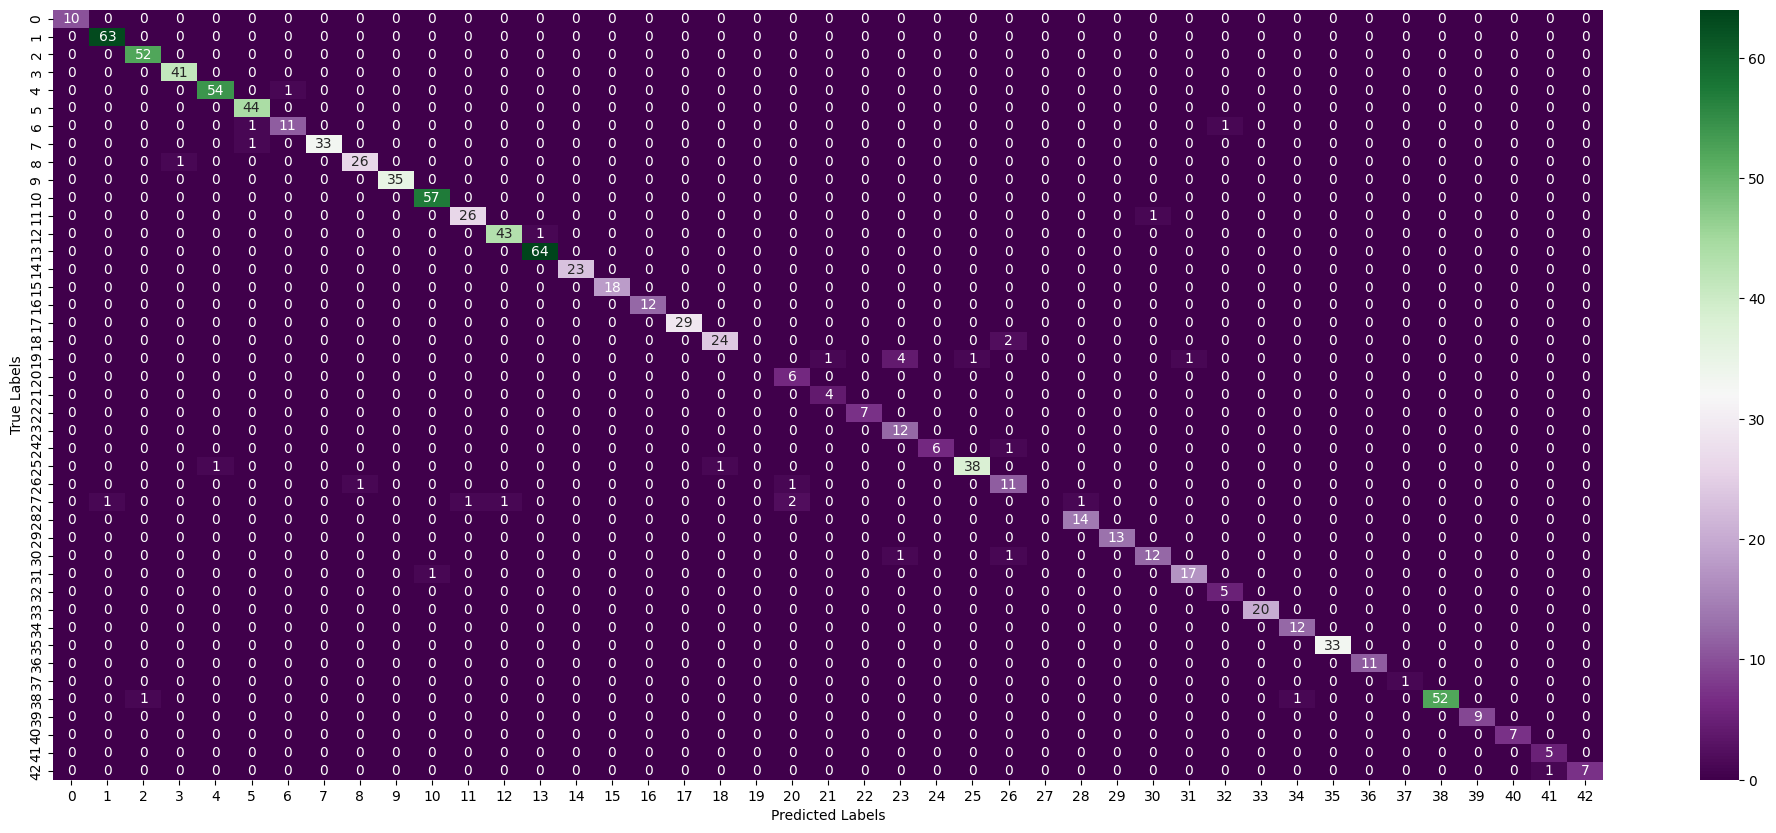

In [ ]:
plt.figure(figsize = (25,10))
sns.heatmap(metrics.confusion_matrix(y_test[:1000], y_pred[:1000]), annot = True, xticklabels = set(y_test), yticklabels = set(y_test), cmap = 'PRGn')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()